# __0. LIBRARIES__

In [143]:
# Standard Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Topic Modeling
# !pip install bertopic  # Uncomment if running in Colab
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

In [144]:
# Random seed setting
rng = 3

__NOTE:__ ALL code withing the 'ASSIGNMENT' block has been commented, as most of it has been adapted later in the code.

_(this was done after reviewing provided code, for easier of re-running the full notebook)_

# __ASSIGNMENT__

In this assignment, you need to analyze a large set of customer reviews and come up with recommendations to the Singapore Airlines CEO to improve customer satisfaction.

The notebook serves as a starting point for your analysis.

At the end of the assignment, you should deliver a five-slide "elevator pitch" to the CEO summarizing your findings and recommendations, backing up your claims with analyses.

## Topic Modeling with Transformers

We have seen that transformers are a powerful tool to build encodings of text that capture context, order of words, etc... Typically, one uses a pre-trained transformer to produce the encodings, and then feeds these to their own model (e.g. a neural network) to solve their particular NLP task, like sentiment analysis or sequence labeling.

In this notebook, you will solve another NLP task called topic analysis (more on that later). You will use the BERTopic package for this task, which is built on top of HuggingFace transformers.

With BERTopic, you will analyze a dataset of Singapore Airlines customer reviews to gain insight into how to improve the customer experience.

You can find an expansive description of the dataset here
https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews


In [145]:
# import pandas as pd
# import matplotlib.pyplot as plt

## Loading the data

We load the data and output some summary of the data columns.

In [146]:
# df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

In [147]:
# df.info()

In [148]:
# df.head()

In [149]:
## If you want to see more text from the review, you can increase the display.max_colwidth

#pd.set_option('display.max_colwidth', 50)

## Quick summary statistics and visualizations

Let's look at some summary statistics for our dataset. For example, are there any interesting trends, or relationships between the length of reviews, presence of specific words, and ratings.

In [150]:
# # Step 1: Calculate the length of each review
# df['review_length'] = df['text'].apply(len)

# # For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
# df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
# df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

# # Preparing data for visualization
# # We'll aggregate data to see if there's a visible trend between the length of reviews, presence of specific words, and ratings
# aggregated_data_rating = df.groupby('rating').agg({
#     'review_length': 'mean',
#     'contains_excellent': 'mean',
#     'contains_terrible': 'mean'
# }).reset_index()

# aggregated_data_rating

In [151]:
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # Review length vs. rating
# axes[0].bar(aggregated_data_rating['rating'], aggregated_data_rating['review_length'], color='skyblue')
# axes[0].set_title('Average Review Length vs. Rating')
# axes[0].set_xlabel('Rating')
# axes[0].set_ylabel('Average Review Length')

# # Presence of "excellent" vs. rating
# axes[1].bar(aggregated_data_rating['rating'], aggregated_data_rating['contains_excellent'], color='lightgreen')
# axes[1].set_title('Presence of "Excellent" vs. Rating')
# axes[1].set_xlabel('Rating')
# axes[1].set_ylabel('Average Occurrence of "Excellent"')

# # Presence of "terrible" vs. rating
# axes[2].bar(aggregated_data_rating['rating'], aggregated_data_rating['contains_terrible'], color='salmon')
# axes[2].set_title('Presence of "Terrible" vs. Rating')
# axes[2].set_xlabel('Rating')
# axes[2].set_ylabel('Average Occurrence of "Terrible"')

# plt.tight_layout()
# plt.show()

We next aggregate the data by year, and plot how the ratings have changed over time.


In [152]:
# df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
# df['year'] = df['published_date'].dt.year
# df.head()

In [153]:
# aggregated_data_rating = df.groupby('year').agg({
#     'rating': 'mean',
# }).reset_index()

# aggregated_data_rating

In [154]:
# plt.bar(aggregated_data_rating['year'], aggregated_data_rating['rating'], color='skyblue')
# plt.title('Average Rating per year')
# plt.xlabel('Year')
# plt.ylabel('Average Rating')

# plt.show()

## Ooops...

There seems to be a meaningful drop in ratings from 2021 onwards. Imagine you report to the Singapore Airlines CEO and you need to formulate a plan of action to improve this situation. It would be nice to see what has gone wrong.

Fortunately, you have the review data that may contain some information about what could be going wrong. This is where topic modeling comes in to help. In short, [topic modeling is a technique that allows you to extract "topics" that occur in a large collection of text](https://en.wikipedia.org/wiki/Topic_model). In this notebook, you will use BERTopic, a topic modeling package built on top of HuggingFace transformers.

Your task is to use BERTopic to explain the negative shift in ratings, and then present your findings as a one-slide pitch that you will present in class.

First, load up BERTopic and familiarize yourselves with its functionality.

## Topic analysis using BERTopic

In this assignment, you will not need to build a transformer per se. What you will do is use an ML package that uses a pre-trained transformer to solve a specific NLP task. In this case, that is topic modeling.

First, if running on Colab (which is highly recommended at least for creating your topic model), you will need to install the package:

In [155]:
# !pip install bertopic

In [156]:
# from bertopic import BERTopic

In [157]:
# topic_model = BERTopic(embedding_model = 'all-MiniLM-L6-v2')

It can take a long time to train the topic model on the entire dataset. To reduce the load, we slice the dataset by year 2019 and run training.

Also, note that so far we are not making any specifications about the training process. The [documentation for BERTopic](https://maartengr.github.io/BERTopic/index.html) gives lots of information on how to tweak the fitting behavior (and how to access different [embeddings](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html), etc.). It also pays to take a look at the [best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html).

In [158]:
# df_slice = df[(df['year'] == 2019)]

In [159]:
# topics, probs = topic_model.fit_transform(df_slice['text'])

Ok, let's see what this topic_model has to say. The following command returns the list of topics ordered by frequency. You can also see the most relevant words for the topic, and the most relevant reviews.

Note: topic -1 is a dummy topic and should generally be ignored. It aggregates all the outliers and reviews that couldn't be clustered into a topic.

In [160]:
# topic_model.get_topic_info()

You can also obtain information on a specific topic. For example below you can look into topic 2 and get the top words for that topic. The numbers on the right quantify the importance of those words to the topic.

In [161]:
# topic_model.get_topic(2)

Here, you can get representative reviews for a topic.

In [162]:
# topic_model.get_representative_docs(2)

You can also visualize topic relationships in 2d space.

In [163]:
# topic_model.visualize_topics()

Or visualize topic word scores.

In [164]:
# topic_model.visualize_barchart()

Finally, it is often handy to visualize the term rank, to see clearly which topics have a particular focus on just a few words.

In [165]:
# topic_model.visualize_term_rank()


Let's organize the topics and reviews in a dataframe.

In [166]:
# topic_df = pd.DataFrame({"topic": topics, "document": df_slice['text']})
# topic_df

## Your Task

Use BERTopic (as well as additional tools you deem useful) to arrive at a set of explanations for the drop in ratings, and a corresponding set of recommendations to the CEO.

You can consult any resources to find out about more of the functionality of BERTopic.

As an example of something you could do, try to slice the data, say by year. What happens when rerun the topic model on the data slice? Is there any menaingful information that comes out?

In general, this is an open-ended exercise. Be creative!

## Deliverables

See the assignment descriptions for a full overview of the deliverables.

# __1. MORE EDA__

After reviewing the assignment summary statistics and visulaizations, I wanted to explore certain aspected of the data further, before starting modeling.

Already observed key insights:
1. Reveiew length is negatively correlated with rating (1 = 920, 5 = 430)
1. Assumtion of __'Exelent'__ appearing more in postive reviews and __'Terrible'__ appearing more in negative reviews, is confirmed. 

Further exploration:
1. Drop `type` column as it only contains a single value _'reveiw'_ (dataset is likely a subset of a larger one)
1. Inspect `titles` column, showing 1 missing value in df.info()
1. Compare average rating across platforms. If one platform rating is significanyly poorer, may indicate on-plain issues with said platform.
1. Analyse monthly trends:
    - First, to explore existance of seasonality afffects on rating.
    - Second, determine if the initial rating drop was in-line with COVID-19 emergence in early 2020
1. Explore other word distributions across rating levels.

Decision questions:
1. How to use `title` column?
    - It is a summary of the `text` column for full reviews 
    - An option would be to use it for suprivised learning for sentiment analysis of our data set, however, with existance of `rating` column it is redunandant.
1. Need for __sentiment analysis__?
    - Topics can include words that do not clearly indicate sentiment, sentiment analysis can help resolve this issue
    - However, given that each review has a `rating` feature, I can calculate the average rating for topics as a proxi sentiment
    - If the proxi proves uninformative, I will consider building or importing a seperate sentiment model

## 1.1. Load and Preprocess the data

In [167]:
# Laod the data
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

# Convert the 'published_date' column to a date format and add 'year' & 'month' columns
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df['month'] = df['published_date'].dt.month

# Remove 'type' column (single value)
df.drop(columns='type', inplace=True)

df.head()

,published_date,published_platform,rating,text,title,helpful_votes,year,month
0,2024-03-12 18:41:14+00:00,Desktop,3,We used this airline to go from Singapore to L...,Ok,0,2024,3
1,2024-03-11 23:39:13+00:00,Desktop,5,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,2024,3
2,2024-03-11 16:20:23+00:00,Desktop,1,"Booked, paid and received email confirmation f...",Don’t give them your money,0,2024,3
3,2024-03-11 11:12:27+00:00,Desktop,5,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,2024,3
4,2024-03-10 09:34:18+00:00,Desktop,2,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,2024,3


## 1.2. Explore 'published_platform'

In [168]:
# Group by platform and calculate average rating
avg_rating_by_platform = df.groupby('published_platform')['rating'].mean().round(2)

# Display
print("Average rating by platform:\n", avg_rating_by_platform)

Average rating by platform:
 published_platform
Desktop    3.96
Mobile     4.16
Name: rating, dtype: float64


In [169]:
# Remove 'published_platform' column (no information)
df.drop(columns='published_platform', inplace=True)

Since the average rating are very simialr across the two platforms, `published_platform` is unlikely to be a significant variable. Therefore, I drop it.

## 1.3. Explote 'title'

In [170]:
# Check for missing values
df.isna().sum()

published_date    0
rating            0
text              0
title             1
helpful_votes     0
year              0
month             0
dtype: int64

In [171]:
# Number of unique values
df['title'].nunique()

8476

In [172]:
# See if there are any identical titles
df[df['title'].duplicated(keep=False)]['title'].value_counts()

title
Singapore Airlines                      57
Excellent service                       57
Great service                           53
Great airline                           43
Excellent                               42
                                        ..
Trip to Oz                               2
A good flight                            2
Disappointed with Singapore Airlines     2
My favourite Airline!                    2
Very Disappointed                        2
Name: count, Length: 466, dtype: int64

In [173]:
# Remove 'published_platform' column (no information)
df.drop(columns='title', inplace=True)

The `title` column contains a single missing valueand meney generic and repeating titles. While titles like 'Excellent service' & 'Very Disspointed' can be usefull for ligh sentiment analysis, other titles like 'Singapore Airlines' add little value. As mentioned above, if average rating will prove redundant, I will consider using title for sentiment, until then, I drop it.

I also considered fusing the `title` and `text` columns to potentially enrich the data or reinforce keywords (mostly sentiment words). However, ultimately decided not to, since it would introduce unnecessary noise, increasing computation time and possibly reducing model performance. Sentiment advantage is taken care of by average rating. 

## 1.4. Monthly ratings review

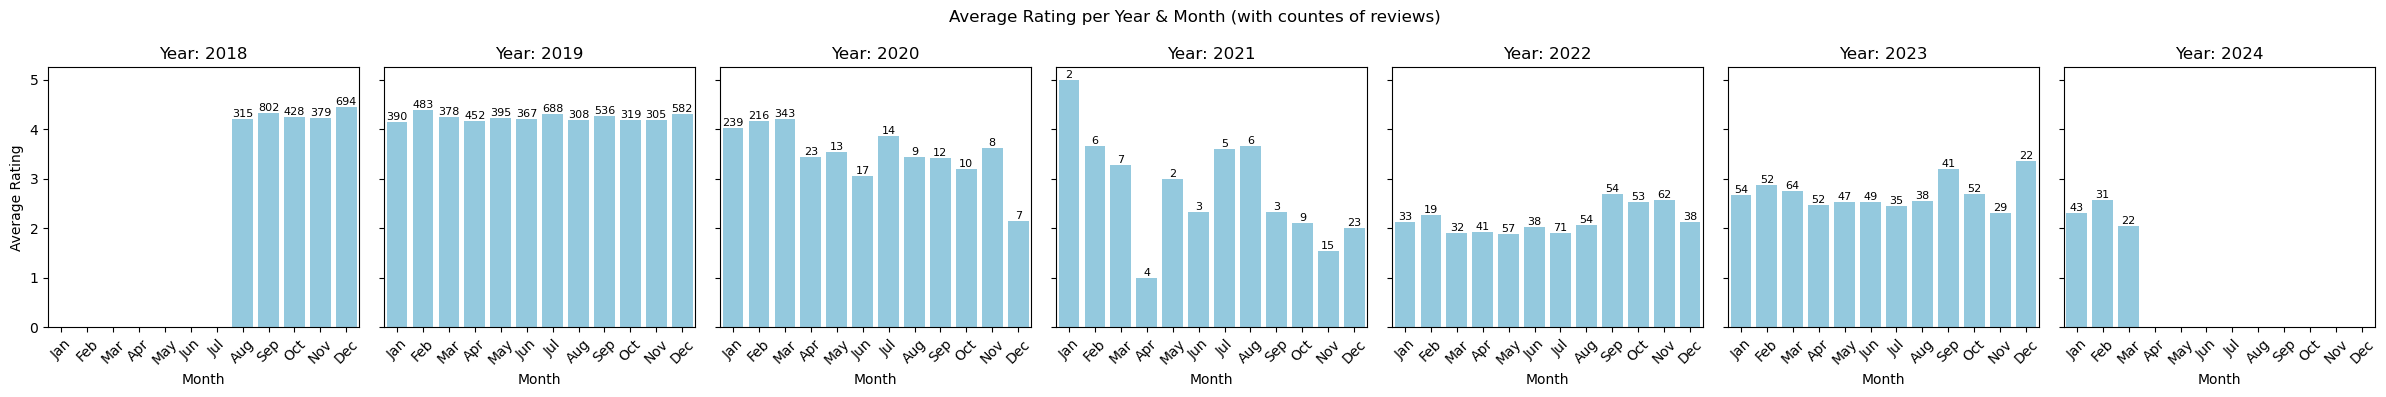

In [174]:
# Prepare data
df_time = df.copy()
df_time['month_name'] = df_time['published_date'].dt.strftime('%b')  # get the month names

# Group by year and month to get avg rating and review count
monthly_summary = df_time.groupby(['year', 'month', 'month_name']).agg(
    avg_rating=('rating', 'mean'),
    review_count=('rating', 'count')
).reset_index()

# Sort time series by ascending year & Jan to Dec
monthly_summary = monthly_summary.sort_values(['year', 'month'])

# Set up the facet subplot layout
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(24, 4), sharey=True)

# Plot each year's data in its respective subplot
for i, year in enumerate(monthly_summary['year'].unique()):
    ax = axes[i]
    data = monthly_summary[monthly_summary['year'] == year]
    bars = sns.barplot(
        data=data,
        x='month_name',
        y='avg_rating',
        order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f"Year: {year}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Average Rating")
    ax.tick_params(axis='x', rotation=45)
    ax.bar_label(ax.containers[0], labels=data['review_count'], label_type='edge', fontsize=8)

# Layout and main title
plt.suptitle("Average Rating per Year & Month (with countes of reviews)")
plt.tight_layout()
plt.show()


Plotting average ratings by month clarifies the start of the decline in ratings __April 2020__. It aligns with the start of global flight ban, reduction and cancellations in March 2020 associated with COVID-19. This justified the reduction ratings from April 2020 until end of 2021. The inconsistent ratings in 2021 are likely due to small number of reviews (e.g. Jan2021 = 2obs).However, the continued low ratings after 2021 suggest long-term issues that are not solely caused by the pandemic.

When modeling it would be particularly interesting to examine if any issues persist across years.

Information source: [World Economic Forum](https://www.weforum.org/stories/2020/03/this-chart-shows-how-airlines-are-being-grounded-by-covid-19/)

## 1.5. Sentance length & word presence across ratings and years (plots)

In [175]:
# Prepare data
df_words = df.copy()

# Calculate the length of each review
df_words['review_length'] = df_words['text'].apply(len)

# Keeping the simple sentiment words, but adding COVID mention and words assosiated with it (cancel & ban)
df_words['contains_excellent'] = df_words['text'].str.contains('excellent', case=False).astype(int)
df_words['contains_terrible'] = df_words['text'].str.contains('terrible', case=False).astype(int)
df_words['contains_covid'] = df_words['text'].str.contains('covid', case=False).astype(int)
df_words['contains_cancel'] = df_words['text'].str.contains('cancel', case=False).astype(int)
df_words['contains_ban'] = df_words['text'].str.contains('ban', case=False).astype(int)

# Preparing data for visualization
# Aggregate data to see if there's a visible trend between the points above and rating
aggregated_data_rating = df_words.groupby('rating').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean',
    'contains_covid': 'mean',
    'contains_cancel': 'mean',
    'contains_ban': 'mean'
}).reset_index()

# Aggregate data to see if there's a visible trend between the points above and year
aggregated_data_year = df_words.groupby('year').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean',
    'contains_covid': 'mean',
    'contains_cancel': 'mean',
    'contains_ban': 'mean'
}).reset_index()

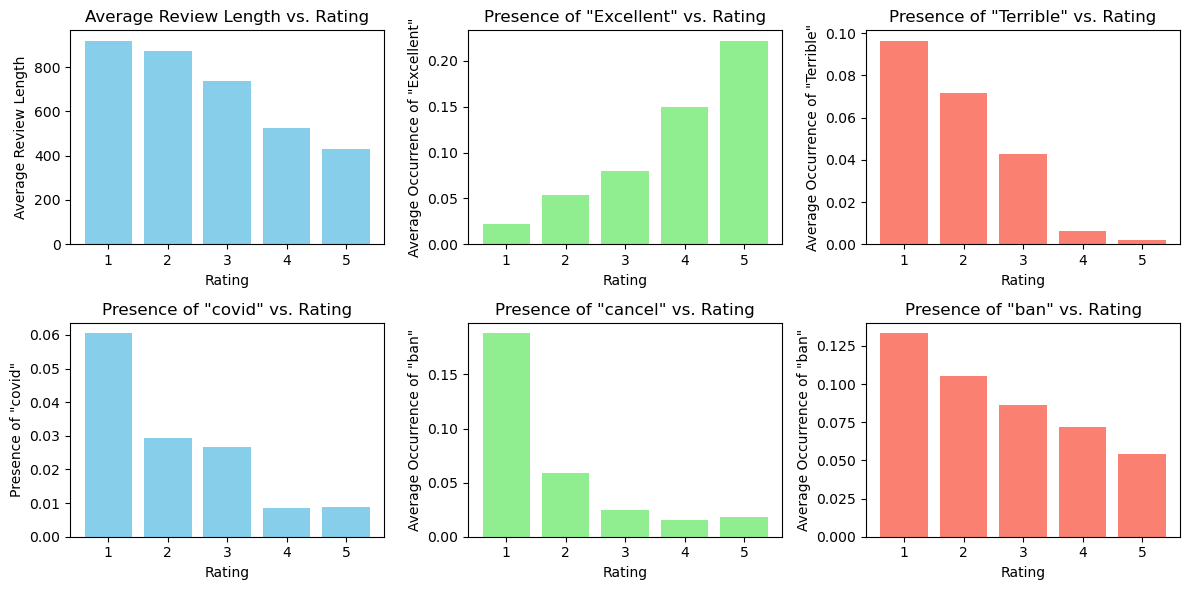

In [176]:
# Rating plots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Review length vs. rating
axes[0][0].bar(aggregated_data_rating['rating'], aggregated_data_rating['review_length'], color='skyblue')
axes[0][0].set_title('Average Review Length vs. Rating')
axes[0][0].set_xlabel('Rating')
axes[0][0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. rating
axes[0][1].bar(aggregated_data_rating['rating'], aggregated_data_rating['contains_excellent'], color='lightgreen')
axes[0][1].set_title('Presence of "Excellent" vs. Rating')
axes[0][1].set_xlabel('Rating')
axes[0][1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. rating
axes[0][2].bar(aggregated_data_rating['rating'], aggregated_data_rating['contains_terrible'], color='salmon')
axes[0][2].set_title('Presence of "Terrible" vs. Rating')
axes[0][2].set_xlabel('Rating')
axes[0][2].set_ylabel('Average Occurrence of "Terrible"')

# Presence of "covid" vs. rating
axes[1][0].bar(aggregated_data_rating['rating'], aggregated_data_rating['contains_covid'], color='skyblue')
axes[1][0].set_title('Presence of "covid" vs. Rating')
axes[1][0].set_xlabel('Rating')
axes[1][0].set_ylabel('Presence of "covid"')

# Presence of "cancel" vs. rating
axes[1][1].bar(aggregated_data_rating['rating'], aggregated_data_rating['contains_cancel'], color='lightgreen')
axes[1][1].set_title('Presence of "cancel" vs. Rating')
axes[1][1].set_xlabel('Rating')
axes[1][1].set_ylabel('Average Occurrence of "ban"')

# Presence of "ban" vs. rating
axes[1][2].bar(aggregated_data_rating['rating'], aggregated_data_rating['contains_ban'], color='salmon')
axes[1][2].set_title('Presence of "ban" vs. Rating')
axes[1][2].set_xlabel('Rating')
axes[1][2].set_ylabel('Average Occurrence of "ban"')

plt.tight_layout()
plt.show()

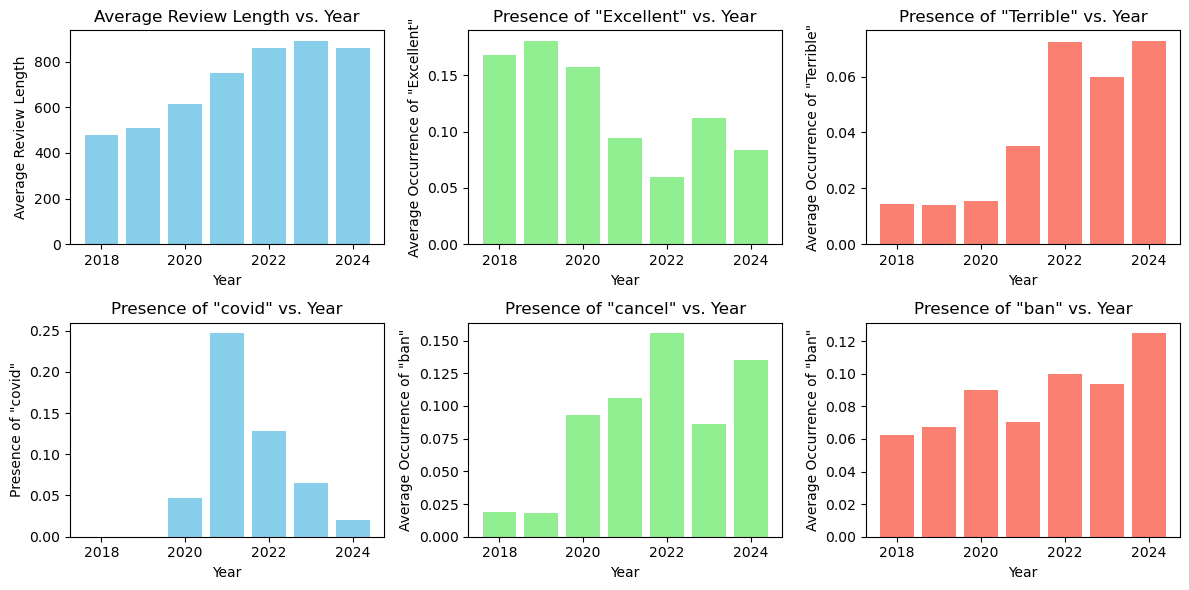

In [177]:
# Years plots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Review length vs. year
axes[0][0].bar(aggregated_data_year['year'], aggregated_data_year['review_length'], color='skyblue')
axes[0][0].set_title('Average Review Length vs. Year')
axes[0][0].set_xlabel('Year')
axes[0][0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. year
axes[0][1].bar(aggregated_data_year['year'], aggregated_data_year['contains_excellent'], color='lightgreen')
axes[0][1].set_title('Presence of "Excellent" vs. Year')
axes[0][1].set_xlabel('Year')
axes[0][1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. year
axes[0][2].bar(aggregated_data_year['year'], aggregated_data_year['contains_terrible'], color='salmon')
axes[0][2].set_title('Presence of "Terrible" vs. Year')
axes[0][2].set_xlabel('Year')
axes[0][2].set_ylabel('Average Occurrence of "Terrible"')

# Presence of "covid" vs. year
axes[1][0].bar(aggregated_data_year['year'], aggregated_data_year['contains_covid'], color='skyblue')
axes[1][0].set_title('Presence of "covid" vs. Year')
axes[1][0].set_xlabel('Year')
axes[1][0].set_ylabel('Presence of "covid"')

# Presence of "cancel" vs. year
axes[1][1].bar(aggregated_data_year['year'], aggregated_data_year['contains_cancel'], color='lightgreen')
axes[1][1].set_title('Presence of "cancel" vs. Year')
axes[1][1].set_xlabel('Year')
axes[1][1].set_ylabel('Average Occurrence of "ban"')

# Presence of "ban" vs. year
axes[1][2].bar(aggregated_data_year['year'], aggregated_data_year['contains_ban'], color='salmon')
axes[1][2].set_title('Presence of "ban" vs. Year')
axes[1][2].set_xlabel('Year')
axes[1][2].set_ylabel('Average Occurrence of "ban"')

plt.tight_layout()
plt.show()

The plots show:
- Mentions of _COVID_ reduced after the pandemic, HOWEVER,
    - Mentions of _cancelation_ remained higher than pre-COVID level
    - Mentions of _ban_ was present even before covid, but increased post-COVID
- Interestingly, average sentance length increased over time, supporting the theory that negative reviews tend to be longer.

# __2. DATA SUBSETS__

To reduce number of comparisons made, while maintating the key obserations across different rating and periods of time, I created customized subsets. After examining each year and rating individually, I tried grouping them and achieved similar results. Therefore, justifing the chosen period and rating ranges for an efficient analysis.

In [178]:
# DF slices for the testing
# Split by year ranges before, during and after covid
df_before = df[(df["published_date"] >= "2018-01-01") & (df["published_date"] < "2020-04-01")]  # years before covid with average rating above 4
df_covid = df[(df["published_date"] >= "2020-04-01") & (df["published_date"] < "2021-12-01")]   # covid years with little reviews and hight monthly rating volatility
df_after = df[df["published_date"] >= "2021-12-01"]                                             # years after covid with average rating between 2 & 3

# By rating:
df_neg = df[(df['rating'] == 1) | (df['rating'] == 2)]
df_avg = df[df['rating'] == 3]
df_pos = df[(df['rating'] == 4) | (df['rating'] == 5)]

# Year ranges split by low (1-2) and high (3-5) ratings
df_before_neg = df_before[df_before['rating'].isin([1, 2])].shape[0]
df_before_pos = df_before[df_before['rating'].isin([3, 4, 5])].shape[0]

df_covid_neg = df_covid[df_covid['rating'].isin([1, 2])].shape[0]
df_covid_pos = df_covid[df_covid['rating'].isin([3, 4, 5])].shape[0]

df_after_neg = df_after[df_after['rating'].isin([1, 2])].shape[0]
df_after_pos = df_after[df_after['rating'].isin([3, 4, 5])].shape[0]

print(
    "===================DATA FRAMES LENGTHS===================",
    f"\nYEARS:   BEFORE = {len(df_before)}, | COVID = {len(df_covid)},     | AFTER = {len(df_after)}\n"
    f"RATINGS: LOW = {len(df_neg)},    | AVERAGE = {len(df_avg)},  | HIGH = {len(df_pos)}\n\n"
    f"BEFORE RATINGS: LOW = {df_before_neg}   | HIGH = {df_before_pos}\n"
    f"COVID RATING:   LOW = {df_covid_neg}    | HIGH = {df_covid_pos}\n"
    f"AFTER RATINGS:  LOW = {df_after_neg}   | HIGH = {df_after_pos}"
)

===================DATA FRAMES LENGTHS=================== 
YEARS:   BEFORE = 8619, | COVID = 175,     | AFTER = 1206
RATINGS: LOW = 1600,    | AVERAGE = 1009,  | HIGH = 7391

BEFORE RATINGS: LOW = 798   | HIGH = 7821
COVID RATING:   LOW = 77    | HIGH = 98
AFTER RATINGS:  LOW = 725   | HIGH = 481


The output shows that most reviews are consentrated in pre-COVID period with 91% positive ratings. During COVID the rating distribution turns more equal with 56% positive. Finally, post-COVID shows 60% of the ratings to be negative. This shows that there are likely new issues that arose post-COVID, that were not presetn before.
I initially considered using the periods devided by rating, but after using _topics over time_ and _topics per class_ visualizations (Section 4), I found them capturing patterns I wanted to explore.

# __3. Basic Model__

I first run the model using it base provided parameters from the assignment (with an addition of random seed for replicability and fair comparison)

In [179]:
# Initiate the model
base_umap = UMAP(random_state=rng, n_jobs=-1)
base_model = BERTopic(embedding_model = 'all-MiniLM-L6-v2', umap_model=base_umap)

# Fit the model
topics, probs = base_model.fit_transform(df_before['text'])

In [180]:
# Topic list by size
base_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,695,-1_the_to_and_was,"[the, to, and, was, in, of, on, for, it, flight]",[I have made this trip a few times on differen...
1,0,5012,0_the_to_and_singapore,"[the, to, and, singapore, was, in, of, we, on,...",[We have just returned from our first flights ...
2,1,2059,1_and_the_was_flight,"[and, the, was, flight, good, food, very, serv...","[Great trip, full plane but the service was ex..."
3,2,183,2_sq_is_the_and,"[sq, is, the, and, to, with, of, always, for, in]",[Picking SQ over others was an obvious choice ...
4,3,130,3_sia_the_to_and,"[sia, the, to, and, of, flight, was, is, for, ...",[I am a frequent traveller and had taken many ...
5,4,119,4_a380_the_was_and,"[a380, the, was, and, on, very, in, flight, it...",[First time flying Airbus A380. Very nice flig...
6,5,118,5_economy_premium_the_seats,"[economy, premium, the, seats, and, for, more,...",[I cannot recommend Premium Economy enough - p...
7,6,103,6_class_the_business_and,"[class, the, business, and, was, economy, to, ...","[We have never flown business class before, so..."
8,7,35,7_emirates_the_airlines_and,"[emirates, the, airlines, and, was, singapore,...",[I have taken many airlines and they are all p...
9,8,30,8_sq_the_is_and,"[sq, the, is, and, to, of, in, have, flight, my]",[I took an SQ flight from Singapore to Bangkok...


Summary: after analyzing topics across years and ratings, the base model results were uninformative. Primary issue being the extreme amounts of stop words. The first step to perform for the  tuning model has to be text vectorization to improve interpretability.

# __4. Fine-Tuned Model__

Fine-tuning of the model i followed the '[Best Practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html)' BERTopic documentation provides. Before starting, I considered whether to fine-tune separate models for each subset or a single model that generilizes across all subsets (more efficient approach). I began by tuning a model for `df_before`, and then applied it to other subsets. The results were good across subsets, with model requiring minimal adjustments to fit all well (this shows that BERTopic model is alreasy great, just requires small adjustments to the data). Given the exploratory nature of the assignment, I believe this approach is justified.

## 4.1. Fine-Tuning & Trainig the Model

Steps of fine-tuning:
1. Applying text vectorization, removing common stop-words, uninformative high-frequency words (data specific), ignoring words that appear once and allowign 1 & 2-gram selection.
    - Although 'Best Practices' apply vectorization after embedding, I priotized it since the topics were hard to interpret otherwise.
    - I attempted using [Additional Representations](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#additional-representations), but experienced installation issues.
1. I tested various [pre-trained embedding models](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html):
    - `"all-mpnet-base-v2"` produced good adn defined topic, but was too slow (even in Colab)
    - `"all-MiniLM-L6-v2"` and `"all-MiniLM-L12-v2"` both prodiced good results in relatively good time, with the latter having slight edge.
1. I removed stochastic behavior of UMAP and attempted changing the  `n_neighbours`, where (original settings yielded best results.): 
    - higher = broader topics
    - lower = finer topics
1. To control the number of topics, there are 2 ways:
    - Using `nr_topics` setting limits the maximum number of topics by "merging topics after they have been created", it was not recomended in the documentation for BERTopic
    - Usings _HDBSCAN()_ changing the `min_cluster_size` and `cluster selection methods` was recomended instead (inderectly controlling numebr of clusters). 
    - I used both, `nr_topics` = 11 and `min_cluster_size` 25 with `'eom'` method. The combination slightly increasing topic count while controlling vague topics, yieldign overall best resutls.
1. After trainign the model, I calculated the average review rating for each topic to estime the sentiment (without the need for additional models).
1. To interpret each topic, I viewed the tokens of topics and read their representative reviews across all subsets. Combined with the topics' average ratings and plots provided insights recoded in the summary (Section 6).

I considered using light summarization model `"sshleifer/distilbart-cnn-12-6"` on represetative documents, but it missed key aspects of the reviews. More advanced models are either too slow or require an API key (e.g., OpenAI).

The data contains `helpful_votes`, using them to give more weight to repective reviews to improve the model (e.g., for better `Representative_Docs`), however, ultimately not implemeted due to additional time required for research and implementation.

In [181]:
# Data
df_slice = df_after

# Using df_covid is not very representative due to little observation in that period with high volatility in ratings

In [182]:
# Improving Default Representation
custom_stopwords = ["singapore", "airline", "flight", "airlines", "sq", "sa", "sia", "air", "flights", 'sin', "fly", "flying"]  # "service" appears often but not across all topics and is key to our analysis
all_stopwords = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))
ft_vectorizer = CountVectorizer(stop_words=all_stopwords, 
                                min_df=2, 
                                ngram_range=(1, 2))   # tried increasing the ngrams taken, but after 2, there was mostly no change

In [183]:
# Pre-calculate Embeddings
ft_embed = SentenceTransformer(               # '*' = consider
    # "all-MiniLM-L6-v2"                      #* standard, not bad at all
    # "all-mpnet-base-v2"                     #* takes very long to fit (>1min for biggest subset in G-colab), topic groupping improvements do not justfy the extra time
    # "all-distilroberta-v1"                  # decent speed, but generated too little concentrated or too many vague topics
    "all-MiniLM-L12-v2"                       #* relatively quick and very good topic seperation across all df subsets (FINAL)
    # "distiluse-base-multilingual-cased-v1"  #* fast and good topic grouppings for df_after, bad for df_before
    # "distiluse-base-multilingual-cased-v2"  # worse than v1, poor groupings
)
# from model2vec import StaticModel
# StaticModel.from_pretrained("minishlab/potion-base-8M")  # extremely fast, but averge topics

In [184]:
# Preventing Stochastic Behavior
ft_umap = UMAP(n_neighbors=15,
               random_state=rng,
               n_jobs=-1)

In [185]:
# Controlling Number of Topics
ft_hdbscan = HDBSCAN(min_cluster_size=25, 
                     metric='euclidean', 
                     cluster_selection_method='eom', 
                     prediction_data=True,
                     core_dist_n_jobs=-1)

In [186]:
# Training
ft_model = BERTopic(
    vectorizer_model=ft_vectorizer,
    embedding_model = ft_embed,
    umap_model=ft_umap,
    hdbscan_model=ft_hdbscan,
    nr_topics=11,

    top_n_words=10,
    verbose=True,
    calculate_probabilities=True
)

# Fit the model
topics1, probs1 = ft_model.fit_transform(df_slice['text'])

2025-04-15 08:25:28,098 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]
2025-04-15 08:25:39,600 - BERTopic - Embedding - Completed ✓
2025-04-15 08:25:39,600 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:25:41,131 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:25:41,132 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:25:41,169 - BERTopic - Cluster - Completed ✓
2025-04-15 08:25:41,170 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:25:41,310 - BERTopic - Representation - Completed ✓
2025-04-15 08:25:41,311 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:25:41,312 - BERTopic - Topic reduction - Number of topics (11) is equal or higher than the clustered topics(9).
2025-04-15 08:25:41,312 - BERTopic - Representation - Fine-tuning topics using representation models.

## 4.2. OUTPUTS: Data (df_slice specific)

In [187]:
# 1. Add topic assignments to the DataFrame
df_temp1 = df_slice.copy()
df_temp1["topic"] = topics1

# 2. Get BERTopic's topic info
topic_info = ft_model.get_topic_info()

# 3. Compute average rating per topic
avg_rating = df_temp1.groupby("topic")["rating"].mean().reset_index()
avg_rating.columns = ["Topic", "Average Rating"]

# 4. Merge with topic info
df_merged1 = topic_info.merge(avg_rating, how="left", on="Topic")

# 5. Reorder columns: Topic, Count, Average Rating, Name
df_merged1 = df_merged1[["Topic", "Count", "Average Rating", "Name", "Representation", "Representative_Docs"]]

# 7. Display
df_merged1


,Topic,Count,Average Rating,Name,Representation,Representative_Docs
0,-1,372,2.268817,-1_service_class_seat_business,"[service, class, seat, business, seats, econom...",[We flew Singapore Airlines to US of A from In...
1,0,32,2.718750,0_service_seat_class_business,"[service, seat, class, business, staff, crew, ...",[I have not flown with SIA for a few years now...
2,1,34,2.500000,1_crew_service_meal_food,"[crew, service, meal, food, 22, used, members,...",[I have used SQ and Changi often and generally...
3,2,63,1.269841,2_luggage_baggage_lost_bag,"[luggage, baggage, lost, bag, days, customer, ...",[Me and my family travelled from Perth to Toky...
4,3,138,3.420290,3_food_good_service_crew,"[food, good, service, crew, great, seat, time,...",[When we arrived at the airport to check in ou...
5,4,268,1.343284,4_customer_ticket_hours_refund,"[customer, ticket, hours, refund, service, boo...",[I booked ROUND TRIP tickets on March 2022 whi...
6,5,36,2.361111,5_economy_premium_premium economy_seat,"[economy, premium, premium economy, seat, seat...",[My wife and I recently flew to and from Sydne...
7,6,41,2.536585,6_class_seat_business_business class,"[class, seat, business, business class, seats,...",[I have flown so many business class airlines ...
8,7,222,3.572072,7_food_service_good_time,"[food, service, good, time, crew, experience, ...",[Flight SQ286 first class Auckland to Singapor...


In [188]:
ft_model.get_topic(0)

[('service', np.float64(0.04070056242139564)),
 ('seat', np.float64(0.023969581416881807)),
 ('class', np.float64(0.023843522615495265)),
 ('business', np.float64(0.023820355342764703)),
 ('staff', np.float64(0.023773597333240838)),
 ('crew', np.float64(0.020299341201850937)),
 ('covid', np.float64(0.01992748075796291)),
 ('good', np.float64(0.01951211692308829)),
 ('ms', np.float64(0.019358867473053556)),
 ('business class', np.float64(0.018583609281728933))]

In [189]:
# Gets all (3) representative tocs for each topic
ft_model.representative_docs_

{-1: ['We flew Singapore Airlines to US of A from India . To  be precise from Chennai to San Francisco and back with flight  change  both ways at  Changi airport in Singapore.We had done some preliminary research of the other airlines too but this one had higher customer approval ratings.\n\nIn the parlance of the the new age flyers, Economy  is often known as  cattle class.Some justification may be seen in that description when one surveys the boarding time scenario. Passengers in  this class  are herded towards the boarding gate  like cattle through a checkpoint where each one is examined and scanned for carrying just one cabin baggage and a valid boarding pass .  As the herd enters the aircraft they need to fall in line and walk past the superior class section to the cramped  narrow aisle way into the economy class section where they start looking for their assigned seats. After finding it they manage to squeeze their usually overstuffed cabin baggage in an already usually overstuff

## 4.3. OUTPUTS: Visualizations (df_slice specific)

In [190]:
# Useful to see the closeness between topics
# ft_model.visualize_hierarchy()

In [191]:
# Visual representation of '.get_topic()' above to see the importance of tokens in each class
# ft_model.visualize_barchart()

In [192]:
# Shows how unique each token is to its topic vs. how common it is globally (e.g., "service" appears often across topics, so ranks lower).
# ft_model.visualize_term_rank()

In [193]:
# Prepare inputs
documents = df_slice["text"].tolist()
timestamps = df_slice["published_date"].tolist()

# Get topics over time
topics_over_time = ft_model.topics_over_time(
    docs=documents,
    topics=topics1,
    timestamps=timestamps,
    nr_bins=17,  # number of months (68) / 4
    evolution_tuning=True,
    global_tuning=True
)

# Visualize
ft_model.visualize_topics_over_time(topics_over_time)
# !!! The plot is interactive. Click legend labels to hide large topics (skewing resutls) to better view smaller ones. !!!

17it [00:00, 37.27it/s]


In [194]:
# Prepare inputs
documents = df_slice["text"].tolist()
class_labels = df_slice["rating"].tolist()  # or a grouped rating column
topic_assignments = topics  # from fit_transform()

# Get topics per class
topics_per_class = ft_model.topics_per_class(
    docs=documents,
    classes=class_labels
)

# Visualize
ft_model.visualize_topics_per_class(topics_per_class)
# !!! The plot is interactive. Click legend labels to choose & compare topics (not recomended having >3 a time). !!!

5it [00:00, 34.34it/s]


# __5. Full Dataset Model__

After finetuning the model in section 4, and discovering `topics_over_time` and `topics_per_class`, I built a model on the entire dataset, only changing the _HDBSCAN_ clusterign method to `'leaf'`.

Although topics were less refined, the model provided a useful overviews of topic distribtuions across full time range and ratings in the dataset, enriching the analysis.

In [195]:
# Controlling Number of Topics
df_hdbscan = HDBSCAN(min_cluster_size=25, 
                     metric='euclidean', 
                     cluster_selection_method='leaf',  # CHANGED: makes more topics (can be poorer, but controlled to an extent through 'nr_topics')
                     prediction_data=True,
                     core_dist_n_jobs=-1)

# Training
df_model = BERTopic(
    vectorizer_model=ft_vectorizer,
    embedding_model = ft_embed,
    umap_model=ft_umap,
    hdbscan_model=df_hdbscan,
    nr_topics=11,

    top_n_words=10,
    verbose=True,
    calculate_probabilities=True
)

# Fit the model
topics2, probs2 = df_model.fit_transform(df['text'])

2025-04-15 08:25:42,441 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 313/313 [01:19<00:00,  3.92it/s]
2025-04-15 08:27:02,431 - BERTopic - Embedding - Completed ✓
2025-04-15 08:27:02,433 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 08:27:11,721 - BERTopic - Dimensionality - Completed ✓
2025-04-15 08:27:11,723 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 08:27:12,382 - BERTopic - Cluster - Completed ✓
2025-04-15 08:27:12,383 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-15 08:27:13,221 - BERTopic - Representation - Completed ✓
2025-04-15 08:27:13,223 - BERTopic - Topic reduction - Reducing number of topics
2025-04-15 08:27:13,230 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-15 08:27:14,098 - BERTopic - Representation - Completed ✓
2025-04-15 08:27:14,101 - BERTopic - Topic reduction - Re

In [196]:
# 1. Add topic assignments to the DataFrame
df_temp2 = df.copy()
df_temp2["topic"] = topics2

# 2. Get BERTopic's topic info
topic_info = df_model.get_topic_info()

# 3. Compute average rating per topic
avg_rating = df_temp2.groupby("topic")["rating"].mean().reset_index()
avg_rating.columns = ["Topic", "Average Rating"]

# 4. Merge with topic info
df_merged2 = topic_info.merge(avg_rating, how="left", on="Topic")

# 5. Reorder columns: Topic, Count, Average Rating, Name
df_merged2 = df_merged2[["Topic", "Count", "Average Rating", "Name", "Representation", "Representative_Docs"]]

# 7. Display
df_merged2

,Topic,Count,Average Rating,Name,Representation,Representative_Docs
0,-1,5638,4.084250,-1_service_food_good_seats,"[service, food, good, seats, seat, time, staff...",[First journey - Melbourne to Delhi on an A350...
1,0,1799,4.306281,0_service_food_good_class,"[service, food, good, class, business, busines...",[We recently flew on Singapore Airlines from A...
2,1,1048,4.544847,1_good_food_service_great,"[good, food, service, great, staff, crew, comf...",[Never failed to live up its expectation as th...
3,2,497,1.861167,2_luggage_customer_refund_ticket,"[luggage, customer, refund, ticket, told, hour...",[I booked ROUND TRIP tickets on March 2022 whi...
4,3,302,4.142384,3_service_crew_good_food,"[service, crew, good, food, class, time, exper...",[I would like to share my feedback on my recen...
5,4,290,3.575862,4_economy_premium_premium economy_seats,"[economy, premium, premium economy, seats, ext...",[Travelled out via Singapore in Economy Class....
6,5,149,4.255034,5_a380_seat_seats_a350,"[a380, seat, seats, a350, good, service, new, ...",[Having not had a remarkable trip on my first ...
7,6,113,2.654867,6_seat_wheelchair_seats_staff,"[seat, wheelchair, seats, staff, asked, told, ...",[This is the worst experience that I have had ...
8,7,76,4.710526,7_kids_baby_food_old,"[kids, baby, food, old, children, kid, year ol...",[Flew from Sydney to Paris on Singapore Airlin...
9,8,62,1.129032,8_customer_customer service_tried_emails,"[customer, customer service, tried, emails, bo...",[I booked a round-trip flight from LAX to Cebu...


In [197]:
# Prepare inputs
documents = df["text"].tolist()
timestamps = df["published_date"].tolist()

# Get topics over time
topics_over_time = df_model.topics_over_time(
    docs=documents,
    topics=topics2,
    timestamps=timestamps,
    nr_bins=20,  # Or set to 'year', 'quarter', or a number of bins
    evolution_tuning=True,
    global_tuning=True
)

# Visualize
df_model.visualize_topics_over_time(topics_over_time)
# !!! The plot is interactive. Click legend labels to hide large topics (skewing resutls) to better view smaller ones. !!!

20it [00:02,  7.91it/s]


Keeping the topic over time plot as is, shows good food and service topic 0 & 1 to skew the results, and while topic 0 sees a return post-COVID, topic 1 continues to drop even after. Removing the two topics to see less populated topics we can see what dominated the reviews. 
- `Yellow` topic 3 line with good service and food, shows high frequency for pre-COVID period, but practically disacppear after the starat of COVID
- `Green` topic 2 line, however, is present before and after covid, it concers luggage loss, poor sustomer service, refunds and bookings. This is an important observartion for understading that negative review surrounding this topic were present even pre-COVID.
- `Light Blue` topic 8 line also reffers to poor customer services and communication which is higher from end of 2021 to mid 2022, could be representative of post-COVID requests back-log processing.

In [198]:
# Prepare Inputs
documents = df["text"].tolist()
class_labels = df["rating"].tolist()  # or a grouped rating column
topic_assignments = topics2  # from fit_transform()

# Get topics per class
topics_per_class = df_model.topics_per_class(
    docs=documents,
    classes=class_labels
)

# Visualize
df_model.visualize_topics_per_class(topics_per_class)
# !!! The plot is interactive. Click legend labels to choose & compare topics (not recomended having >3 a time). !!!

5it [00:00,  6.78it/s]


While topics 0, 1, 3, 5, 7 are mostly rated 5, topics 2, 6, 8, 9 are mostly rated 1, which is obvious from their average ratings. However, looking at Topic 4, we know the average rating to be 3.58, however the distribution is across ratings is significantly skewed towards 5.

# __6. SUMMARY OF RESULTS__

Summary results are based on the outputs of the `ft_model` traiend on the respective datasets. The findings were reviewed, condensed and summarized to their key insights.

### __6.1. BEFORE COVID:__
- Topics (excl. -1): 7
- Overall Sentiment: Largely positive, with average ratings ranging from 4.19 to 4.57.
- Outliers Topic `-1` includes strong negative feedback, with average rating 3.85

Positive mentions:
- __Food & Staff Quality__ (mentioned most frequently particularly by topic 1)
    - Topics: 0, 1, 4
    - Great food/ attentive and helpful staff/ overall pleasant experience
- __Classes__
    - Topics: 4, 5
    - Praised business class wine selection/ clean (premium)economy/ responsive crew
- __Family/Kids Travel__
    - Topics: 2
    - Kids friendly services/ toys, bassinet seats/ warm & understanding crew

Negative mentions:
- __Poor Custumer Service & Confusing Booking Experience__
    - Topics: -1
    - Confusing upgrade policies/ overcharging/ paid-for seats unavailable/ delays/ poor customer service
- __Business and Economy Classes__
    - Topics: 3, 4
    - Overpriced/ outdated business design/ poor meal timing
- SilkAir is considered as 'dragging' SIA's reputation due to poor sevices (even for budget)

### __6.2. DURING COVID:__
- Topics (excl. -1): 3
- Overall Sentiment: Mixed, with average ratings ranging from 2.46 to 4.17.

Positive mentions:
- __Good Experince__
    - Topics: 1
    - Professional & freindly crew/ clean planes/ good food

Negative mentions:
- __Refunds & Customer Service__ (this was during COVID!)
    - Topics: 0
    - Dissatisfaction with return handling (first & business class extra)/ lack of transperancy & communication (months call-back wait)/ long & partial refunds
- __Premium Economy Steating__
    - Topics: 1
    - Overpriced/ minimal upgrades over standard/ identical food

### __6.3. AFTER COVID:__
- Topics (excl. -1): 8
- Overall Sentiment: Generally negative, topics' average rating below 2.5 with exception of 2 topics above 3.5

Positive mentions:
- __Good Experince__  (for long distance & first class)
    - Topics: 3, 7
    - Premium dining/ attentive & professional crew (inconsistent)/ KrisWorld entertainment/ nice design and clean (especially econ)

Negative mentions:
- __Luggage__
    - Topics: 2
    - lost bags/ lack of transperancy & communication/ rude agents/ missed compensations
- __Refunds, Customer Service, Booking__
    - Topics: 4
    - poor communication/ booking errors/ inflexible booking policies/ poor refund policies
- __Premium Economy__
    - Topics: 5
    - Overpriced/ minimal upgrades over standard/ no food upgrades/ other airlines are better for the price
- __Other__
    - Againg aircracfts/ poor meal quality/ inconsistent crew professionalism/ poor special needs and medical assistance

### __6.4. POSITIVE RATING:__
- Topics (excl. -1): 9
- Overall Sentiment: Average rating ranges 4.70 to 4.89 (makes sence since it is purely positve)

Mentions:
- __Refunds, Tickets & Cancellation Handling__  (for long distance & first class)
    - Topics: 9 (relatively small cluster of 36obs)
    - fast resolution/ transparent communication/ flexible policy during COVID
- __Food & Staff Quality__
    - Topics: 5, 7, 8
    - crew warmth/ friendly connection (post-COVID)/ expereince consitency/ great food
- __Child-Friendly__
    - Topics: 6
    - crew patience & support/ toys/ bassinets/ snaks/ better compared to rivals
- __Comfort & Features__
    - Topics: 0, 2
    - Comfort in business (especially A380/350)/ in-flight entertainment/ seat design/ on-time boarding/ friendly lounges/ smooth landing

Looking at the topics over time plot, the frequency of these topics drops in-line with the pandemic and practically disappears after 2022. Topics 1 and 0 do get mentioned to an extent, but not at pre-COVID levels.

### __6.5. AVERAGE RATING:__
- Topics (excl. -1): 8
- Overall Sentiment: Average rating 3

Mentions:
- __Premium Economy__  (for long distance & first class)
    - Topics: 1
    - _Positives_: leg-room/ priority boarding
    - _Negatives_: treated like economy/ shared restrooms/ economy food/ overpriced
- __Economy & Staff__
    - Topics: 2, 3
    - _Positives_: polite crew (inconsistent)/ on-time departures
    - _Negatives_: uncomfortable seats/ cold & dirty seats/ vegeterian and special meals misshandled/ inconsistent crew service
- __Long Flights & Business Class__
    - Topics: 0, 4, 5, 7
    - _Positives_: spacious/ patient staff (inconsistent)/ bar options/ families are treated nice
    - _Negatives_: poor seat comfort (777 & A330)/ food quality & portions lack/ outdated lounge/ poor children meals
- __Members__
    - Topics: 6
    - _Positives_: complimentary upgrades sometimes
    - _Negatives_: little recognition of Star Alliance Gold/ United elites etc./ Lounge quality lacking

Looking at the topics over time plot, the frequency of these topics drops in-line with the pandemic and practically disappears after 2021. However, to begin with, rating of 3 is least commom rating, likely because reviews are often based on strong emotion (positive or negative).

### __6.6. NEGATIVE RATING:__
- Topics (excl. -1): 7
- Overall Sentiment: Average rating ranges 1.06 to 1.57 (makes sence since it is purely negative)

Mentions:
- __Service Crew__  (for long distance & first class)
    - Topics: 0
    - inconsistent and poor staff quality/ boarding inefficiencies (long taxiing, delays, class miss-priority)
- __Luggage__
    - Topics: 1
    - frequent luggage missplacement on connecting flights/ poor customer service regarding luggage recovery/ delayed recovery/ dismissive staff
- __Seats & Food__
    - Topics: 2, 5, 6
    - overprices premium/ no distinction from standard (meals, facilities)/ rude cabin crew/ poor design business and economy/ low quality meals (mentioned post-COVID more)/ poor handling dietary needs
- __Customer Service & Refunds__
    - Topics: 3, 4
    - unresponsive customer support (emails, calls)/ refund delays, undercompensation & failures/ poor booking & editing system/ inaccurate information from customer services/ poor communication of changes

Looking at the topics over time plot, the frequncy of these topics reduces during COVID (like all other expected), but returns towards the end of 2021. While the frequency is similar to pre-COVID, relative to the positve and average resposes it increased significantly.

# __7. RECOMMENDATIONS__

The recommendations are in a listed in the order of importance to the Singapore Airlines (SQ). Within the reccomendations, outside of describing and reasoning my recommendation, I will mention what SIA are already doing well and need to preserve if there are points applicable.

## 7.1. Update Customer Service System

Customer service issues were not only one of the most common issues mentioned in the reviews, but also consistent across pre- and post-COVID periods. When looking at only negative reviews, it has the lowest average ratings of 1.06 & 1.13 (`df_neg`, _Topics 3 & 4_). Passengers mention long wait times, unreturned emails, rude or misinformed agents and overall lack of transparency, especially when requiring support for refunds (being delayed, undercompensated or denied). Refund and customer support were often mentioned in the same reviews and topics, these were the lowest rated topics with harshest reviews, with some reviews stating they "reported SIA to the Department of Transportation". To regain customer confidence SQ must invest in an improved customer service system. It should include smarter AI-Chatbots to handle minor queries (current bots were reported often unhelpful), an automated refund system for small and non-regular claims (personnel dedicated to prioritise larger claims), and auto-generated communication updates for flight timeline, status changes and disruptions. Additionally, more human agents must be re-trained to be professional, consistent, well-informed and empathetic to customers. Finally, during high-traffic periods (e.g., early post-COVID months), the number of agents on-call should increase. Satisfying these recommendations will improve SQ's image, reduce response time (and customer frustration) and improve average ratings.

## 7.2. Redesign the Booking System

To reinforce the Section 7.1, SQ needs to redesign its booking system. Across tested dataframes, customers mention malfunctioning and confusing booking experience (pre- and post-COVID). Passengers encounter problems with changing travel dates, seats, upgrade classes, and cancel flights, often requiring them to seek online assistance (linking back to Section 7.1 recommendation). The issue causes vary from system processing delays, price fluctuations during booking, and incorrect information presented during booking resulting in incorrect bookings. Investing in a modernized booking system that is real-time synchronized with the database and has a more customer-friendly User Interface for amending bookings is a requirement in today's world, where small quality-of-life digital improvements are appreciated by the end-users. The improvement would reduce the need for customer support services (supporting Section 7.1) and boost SQ to the digital standard of other airlines. 

Finally, frequent flyers report the lack of their recognition (`df_avg`, _Topic 6_), Alliance Gold and United Elites were specifically mentioned. Integrating a system to recognise such flyers and offer them additional services (e.g., lounge) can capture a previously dissatisfied customer segment.

## 7.3. Improve Services to Pre-COVID Standards

Moving away from long-term issues, after COVID, the passengers report crew to be 'inconsistent', 'robotic', dismissive and  lacking empathy (similar to Section 7.1). This suggests a post-COVID culture shift in the crew that damages SQ's reputation. SQ must perform a standardized service re-training program across their teams (in-flight crew, luggage handling, lounge) ensuring to promote consistency, warmth and professionalism. To incentivize this, SQ can hire 'mystery-flyers' that evaluate the performance of the staff, and given a good evaluation, the staff would receive a minor salary bonus (performed on a monthly basis). SQ customers also rate highly when the crew is helpful and understanding with children, therefore the crew should pay extra attention to such passengers (providing toy packages and helping with formula bottles were mentioned in highly rated reviews). Clean planes are also praised in highly rated reviews, but post-COVID passengers report inconsistencies, the re-training program should bring tidiness back to standard.

Additionally, post-COVID there was a significant increase in luggage mishandling and loss, particularly for connecting flights (`df_after`, _Topics 1 & 2_). Some issues were reported to be due to communication causing issues in getting luggage back (further highlighting the need for Section 7.1), but the root cause is the luggage handling itself. Therefore, the re-training program for ground personnel should help to reduce luggage loss. Adding a similar to 'mystery-flyer' bonus system (e.g., set bonus on top of base salary, reduced for every mishandled baggage), should ensure follow-through. 

Finally, food which was mostly praised during pre-COVID periods, is now showing average ratings below 3.6 (`df_after`, _Topics 1 & 3 & 7_). While not as prevalent as issues mentioned so far, customers do report issues with handling dietary needs and boring food choices. Custom dietary needs can be improved through re-training and improved booking system, however, SQ needs to consider diversifying food options (at least to higher class passengers).

## 7.4. Satisfy the Classes

Final recommendation concerns premium economy and business class passengers. The segment is smaller, however, significant. Premium economy passengers report (pre- & post-COVID) dissatisfaction with minimal difference to economy considering it overpriced. Main issues mentioned are in-flight meals and drinks being the same as economy and shared facilities with economy, however, enjoying the extra leg-room. Improving the meal quality (e.g., offering cheap wine) and restricting the use of a bathroom to premium economy should resolve these concerns at minimal added costs, however, bathroom restriction may lead to an increase in negative reviews from economy class (single bathroom may not be enough).

Business class passengers have specific complains. They state that the planes [Boeing 777s](https://en.wikipedia.org/wiki/Boeing_777) and [Airbus A330s](https://en.wikipedia.org/wiki/Airbus_A330) (both released pre-2000) are outdated and would like to see more Airbus [A350s](https://en.wikipedia.org/wiki/Airbus_A350) and [A380s](https://en.wikipedia.org/wiki/Airbus_A380) (released post-2000). This would require significant investment and before that a detailed cost analysis (additional revenue from new model satisfaction against costs incurred). I will mention that business class passengers highly praise the bar menu option, so ensuring its availability or even improving it could boost their satisfaction as well.